In [1]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind

# Configuración
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames


# Gestión de los warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../../files/df_nulos_imputados.csv", index_col=0)

Revisamos las tres columnas de satisfacción y sus medias/medianas

In [3]:
df[['EnvironmentSatisfaction' , 'JobSatisfaction' , 'RelationshipSatisfaction']].agg(['mean' , 'median'])

,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction
mean,1.104287,2.730646,2.714012
median,1.000000,3.000000,3.000000


Observamos que las encuestas de environment satisfaction son muy bajas en comparación con job y relationship satisfaction, lo cual puede impactar en la media resultante. Por tanto, decidimos hacer una media ponderada y darle un peso determinado a cada una de las variables para tratar de mitigar dicho impacto:

**Distribución de pesos**
- EnvironmentSatisfaction: 20%
- JobSatisfaction: 40%
- RelationshipSatisfaction: 40%

Creamos la columna de Overall Satisfaction haciendo la media ponderada

In [4]:
# Definimos los pesos
weights = {
    'EnvironmentSatisfaction': 0.20,
    'JobSatisfaction': 0.40,
    'RelationshipSatisfaction': 0.40
}

# Calculamos la media ponderada
df['OverallSatisfaction'] = round(
    df['EnvironmentSatisfaction'] * weights['EnvironmentSatisfaction'] +
    df['JobSatisfaction'] * weights['JobSatisfaction'] +
    df['RelationshipSatisfaction'] * weights['RelationshipSatisfaction']
, 0)

# Convertimos los resultados a integer
df['OverallSatisfaction'] = df['OverallSatisfaction'].astype('int64')

Creamos la columna de satisfacción en base al Overall Satisfaction

In [5]:
df['TestGroup'] = df['OverallSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

Hacemos una tabla de contingencia y analizamos los datos

In [6]:
tabla_contingencia_porcentaje = pd.crosstab(df['TestGroup'], df['Attrition'], normalize = True) * 100
tabla_contingencia = pd.crosstab(df['TestGroup'], df['Attrition']) 
tabla_contingencia

Attrition,No,Yes
TestGroup,,
insatisfechos,638,144
satisfechos,673,108


In [7]:
tabla_contingencia_porcentaje

Attrition,No,Yes
TestGroup,,
insatisfechos,40.818938,9.213052
satisfechos,43.058221,6.909789


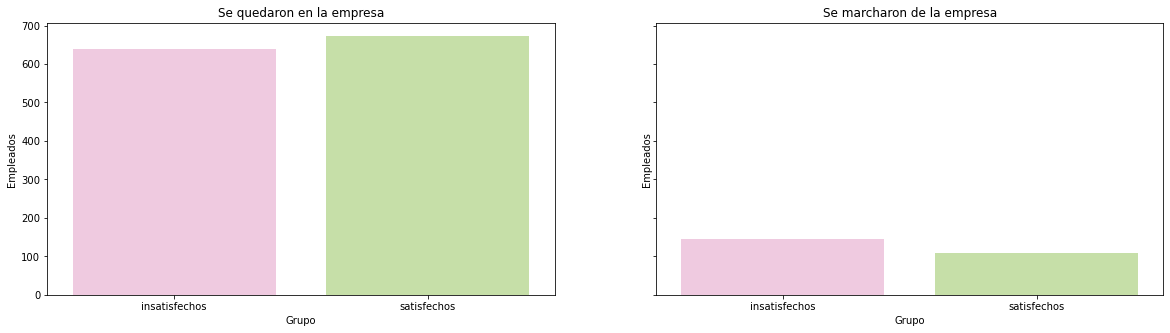

In [8]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia.index, y="No", data=tabla_contingencia,  palette = "PiYG", ax = axes[0])
sns.barplot(x=tabla_contingencia.index, y="Yes", data=tabla_contingencia,  palette = "PiYG", ax = axes[1])

axes[0].set_title("Se quedaron en la empresa")
axes[1].set_title("Se marcharon de la empresa")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("Empleados");

In [9]:
# Realizar la prueba de proporciones
chi2, p_value, _, _ = chi2_contingency(tabla_contingencia)

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print(f"Con un p_value de {p_value} hay una diferencia significativa en la cantidad de attrition según el grupo")
else:
    print(f"Con un p_value de {p_value} no hay una diferencia significativa en la cantidad de attrition según el grupo")

Con un p_value de 0.01656162686117298 hay una diferencia significativa en la cantidad de attrition según el grupo


Revisamos las columnas de satisfacción por separado

In [10]:
df2 = df.copy()

In [11]:
df2['Test_Env'] = df2['EnvironmentSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

In [12]:
tabla_contingencia2 = pd.crosstab(df2['Test_Env'], df2['Attrition']) 

In [13]:
# Calcular el porcentaje para 'No' en cada fila
tabla_contingencia2['No %'] = tabla_contingencia2['No'] / (tabla_contingencia2['No'] + tabla_contingencia2['Yes']) * 100

# Usar los valores originales de 'Yes' para calcular el porcentaje en cada fila
tabla_contingencia2['Yes %'] = tabla_contingencia2['Yes'] / (tabla_contingencia2['No'] + tabla_contingencia2['Yes']) * 100

# Mostrar el DataFrame actualizado
tabla_contingencia2.drop(['No' , 'Yes'], inplace = True, axis = 1)

In [14]:
tabla_contingencia2

Attrition,No %,Yes %
Test_Env,,
insatisfechos,83.597884,16.402116
satisfechos,92.156863,7.843137


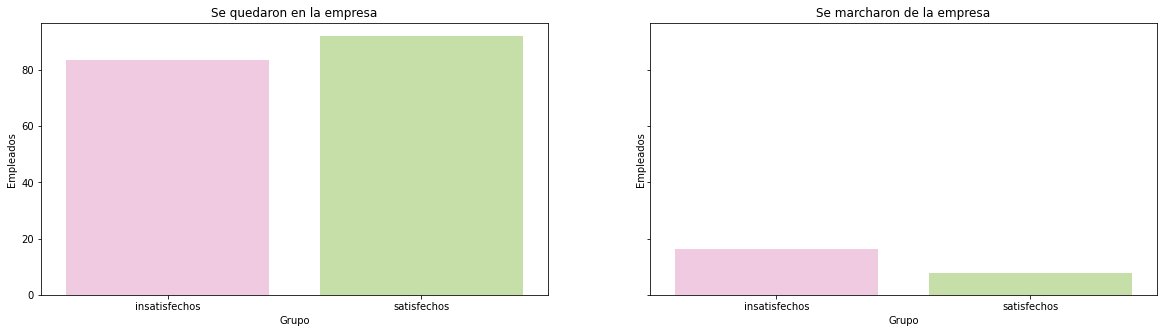

In [15]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia2.index, y="No %", data=tabla_contingencia2,  palette = "PiYG", ax = axes[0])
sns.barplot(x=tabla_contingencia2.index, y="Yes %", data=tabla_contingencia2,  palette = "PiYG", ax = axes[1])

axes[0].set_title("Se quedaron en la empresa")
axes[1].set_title("Se marcharon de la empresa")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("Empleados");

In [16]:
df2['Test_Job'] = df2['JobSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

In [18]:
tabla_contingencia3 = pd.crosstab(df2['Test_Job'], df2['Attrition']) 
tabla_contingencia3

Attrition,No,Yes
Test_Job,,
insatisfechos,486,121
satisfechos,825,131


In [19]:
# Calcular el porcentaje para 'No' en cada fila
tabla_contingencia3['No %'] = tabla_contingencia3['No'] / (tabla_contingencia3['No'] + tabla_contingencia3['Yes']) * 100

# Usar los valores originales de 'Yes' para calcular el porcentaje en cada fila
tabla_contingencia3['Yes %'] = tabla_contingencia3['Yes'] / (tabla_contingencia3['No'] + tabla_contingencia3['Yes']) * 100

# Mostrar el DataFrame actualizado
tabla_contingencia3.drop(['No' , 'Yes'], inplace = True, axis = 1)

In [20]:
tabla_contingencia3

Attrition,No %,Yes %
Test_Job,,
insatisfechos,80.065898,19.934102
satisfechos,86.297071,13.702929


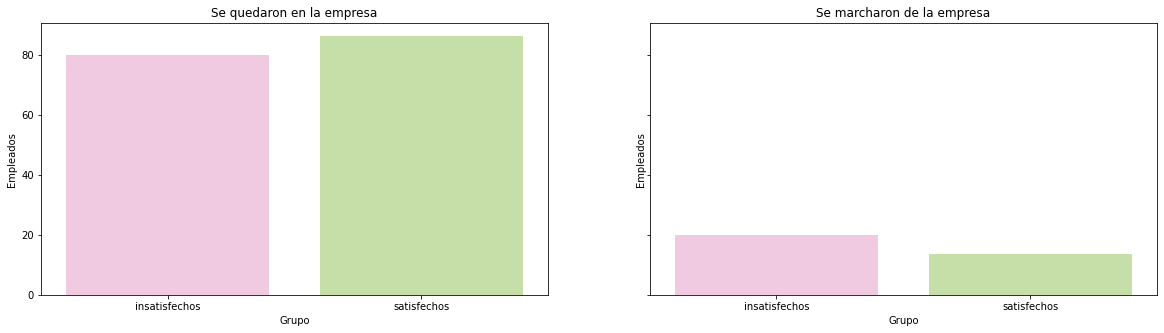

In [21]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia3.index, y="No %", data=tabla_contingencia3,  palette = "PiYG", ax = axes[0])
sns.barplot(x=tabla_contingencia3.index, y="Yes %", data=tabla_contingencia3,  palette = "PiYG", ax = axes[1])

axes[0].set_title("Se quedaron en la empresa")
axes[1].set_title("Se marcharon de la empresa")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("Empleados");

In [22]:
df2['Test_Rel'] = df2['RelationshipSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

In [23]:
tabla_contingencia4 = pd.crosstab(df2['Test_Rel'], df2['Attrition']) 
tabla_contingencia4

Attrition,No,Yes
Test_Rel,,
insatisfechos,511,106
satisfechos,800,146


In [24]:
# Calcular el porcentaje para 'No' en cada fila
tabla_contingencia4['No %'] = tabla_contingencia4['No'] / (tabla_contingencia4['No'] + tabla_contingencia4['Yes']) * 100

# Usar los valores originales de 'Yes' para calcular el porcentaje en cada fila
tabla_contingencia4['Yes %'] = tabla_contingencia4['Yes'] / (tabla_contingencia4['No'] + tabla_contingencia4['Yes']) * 100

# Mostrar el DataFrame actualizado
tabla_contingencia4.drop(['No' , 'Yes'], inplace = True, axis = 1)

In [25]:
tabla_contingencia4

Attrition,No %,Yes %
Test_Rel,,
insatisfechos,82.820097,17.179903
satisfechos,84.566596,15.433404


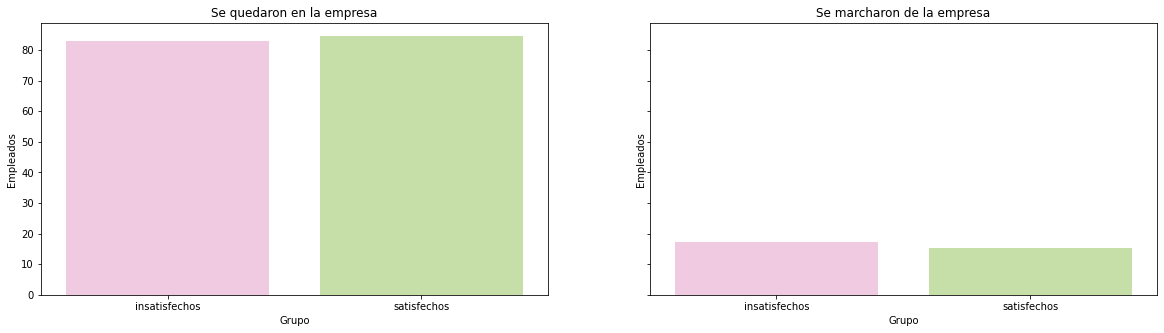

In [26]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia4.index, y="No %", data=tabla_contingencia4,  palette = "PiYG", ax = axes[0])
sns.barplot(x=tabla_contingencia4.index, y="Yes %", data=tabla_contingencia4,  palette = "PiYG", ax = axes[1])

axes[0].set_title("Se quedaron en la empresa")
axes[1].set_title("Se marcharon de la empresa")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("Empleados");

** Análisis **

- observando las medias, nos dimos cuenta que debido al elevado número de insatisfechos que tiene EnvironmentSatisfaction no podíamos sacar conclusiones objetivas. 
- calculamos la media ponderada, dandole más peso a aquellas variables que no estaban tan desviadas (Jobsatisfaction y RelationshipSatisfaction)
- ahora sí se observan diferencias significativas al hacer una media ponderada de estas tres, por lo que concluimos que el nivel de satisfacción sí es un factor determinante en la rotación de empleados en la empresa. 
- Revisando los porcentajes en las distintas encuestas de satisfacción, también observamos: 
        - el factor más influyente en la decisión de abandonar la empresa es el ambiente laboral, seguido por el trabajo (JobSatisfaction)
        - así mismo, las relaciones laborales no parecen tener mucha importancia